The following tutorial introduces dynamic simulations (RMS/EMT), plotting and exporting of results (to csv) using *powfacpy*.

Let's again set up *PowerFactory* and create an instance of the class `PFPlotInterface`. This class inherits from `PFBaseInterface` (so those methods are available).

In [1]:
# If you use IPython/Jupyter:
import sys
sys.path.append(r'C:\Program Files\DIgSILENT\PowerFactory 2022 SP1\Python\3.10') # you may use a different directory
# Get the PF app
import powerfactory
app = powerfactory.GetApplication()
import powfacpy
app.Show()
app.ActivateProject(r"\seberlein\powfacpy\powfacpy_tests") # You may change the project path.
# Make sure the path starts with "\"
pfpi = powfacpy.PFPlotInterface(app)
pfpi.activate_study_case(r"Study Cases\test_plot_interface\Study Case 1")

In *PowerFactory*, result variables that ought to be monitored (to be later plotted or exported) need to be specified before the simulation. The easiest way to plot results using *powfacpy* is to simply use the method `plot` before the simulation, which automaticallly adds a varibale to the monitored variables and plots it as soon as the simulation is run.

First, we set the active plot (starting from a clean graphics board by clearing all plot pages).

In [2]:
pfpi.clear_plot_pages() # Start from a clean graphics board
pfpi.set_active_plot("Plot 1","Plot page 1")

The method `set_active_plot` takes the name of the plot and the name of the page of the plot as input arguments. If the plot (or the page) does not exist, it is created. If there should be several plots on one page, the method is called several times with the same page name but different plot name (e.g. `pfpi.set_active_plot("Plot 2","Plot page 1")`). 

All plot commmands are applied to the active plot. We can now add curves to the plot.

In [3]:
# Curve of variable "s:Iqcmd"
pfpi.plot(r"Network Model\Network Data\test_plot_interface"
    r"\Grid 1\WECC WT Control System Type 4A\REEC_A Electrical Control Model",
    "s:Iqcmd")
# Curve of variable "s:Ipcmd"
# Prepare arguments
dsl_controller_obj = pfpi.get_single_obj(r"Network Model\Network Data"
    r"\test_plot_interface\Grid 1\WECC WT Control System Type 4A\REEC_A Electrical Control Model")
results_obj = pfpi.get_single_obj(r"Study Cases\test_plot_interface\Study Case 1\All calculations")
# Plot with keyword arguments
pfpi.plot(dsl_controller_obj,
    "s:Ipcmd",
    linestyle = 3,
    linewidth = 200,
    color = 5,
    label = "Reactive power setpoint",
    results_obj = results_obj)

The method `plot` takes the PF object and its variable as first and second input. Furthermore, keyword arguments can be specified as shown for the second curve. 

Now we can execute a dynamic simulation using the dynamic simulation interface class.

In [4]:
pfds = powfacpy.PFDynSimInterface(app)
pfds.initialize_sim({"iopt_sim":"rms"})
pfds.run_sim({"tstop":0.5})

The two methods initialize and run the simulation. Paramters for the ComInc object (initialization) and the ComSim (run simulation) can be specified in a dictionary. If no parameters need to be set, one can also use:

In [5]:
pfds.initialize_and_run_sim()

In some cases, it might be more convenient to add the result variable first, then simulate and finally specifiy the plot:

In [6]:
dsl_controller_obj = pfpi.get_single_obj(r"Network Model\Network Data"
    r"\test_plot_interface\Grid 1\WECC WT Control System Type 4A\REEC_A Electrical Control Model")
pfds.add_results_variable(dsl_controller_obj,"s:Ipcmd")
pfds.initialize_and_run_sim()
pfpi.plot(dsl_controller_obj,"s:Iqcmd")

So the method `add_results_variable` is used to add variables to the monitored vaiables to later export or plot them.

Sometimes we have created plots in one study case and want to have those plots also in another study case. This can be achieved by copying the graphics board content (or parts of it) from one study case to another:

In [7]:
study_case_1 = pfpi.get_single_obj(r"Study Cases\test_plot_interface\Study Case 1")
study_case_2 = pfpi.get_single_obj(r"Study Cases\test_plot_interface\Study Case 2")
pfpi.copy_graphics_board_content(study_case_1,study_case_2,"*.GrpPage")

This copies all plot pages (class GrpPage) of Study Case 1 to Study Case 2. The target study case argument can also be a list of cases. Or we can use the method `copy_graphics_board_content_to_all_study_cases` to target all study cases or all cases in a certain folder.

To use simulation results outside PowerFactory we can eport them to csv format:

In [8]:
pfds.export_to_csv()

This exports the result object of the active study case to the directory from where the script is run. You can also specifiy a directory, a file name (default is "results") or a results object (ElmRes) from where the data is exported. 

The formatting of the exported csv file looks like this: the first line specifies the path of the variable (object path + variable name), e.g. "Network Model\Network Data\test_plot_interface\Grid 1\WECC WT Control System Type 4A\REEC_A Electrical Control Model\s:Iqcmd" in all columns except for the first one, which is "Time". The remaining rows contain the values of the variables.

The static method `plot_from_csv` is used to plot from files of this format:

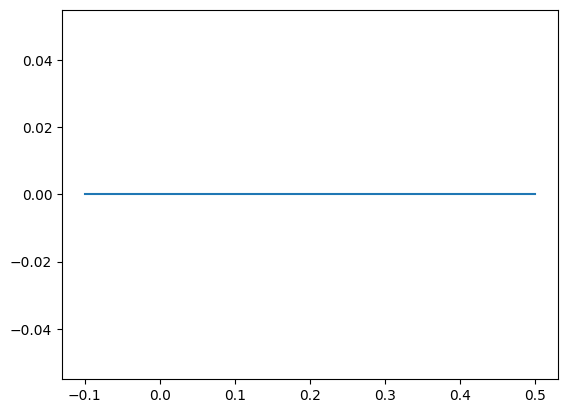

In [9]:
plot = powfacpy.PFPlotInterface.plot_from_csv("results.csv",r"Network Model\Network Data"
    r"\test_plot_interface\Grid 1\WECC WT Control System Type 4A\REEC_A Electrical Control Model\s:Iqcmd")  

*Pyplot* is used by default, but you can specify a different plot interface using the optional argument `plot_interface`.